In [79]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model
from skimage import io
import pyvista as pv
from trimesh import smoothing, Trimesh, proximity
from trimesh.curvature import discrete_mean_curvature_measure,sphere_ball_intersection


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
all_df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
    _df = _df.drop_duplicates().sort_index().reset_index()
    _df['Region','Meta'] = name
    _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
    _df = _df.set_index(['Frame','TrackID'])
    all_df.append(_df)

all_df = pd.concat(all_df)
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}

dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))

In [84]:
# # Load adjacency maps

# adj_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/W-R1/Mastodon/basal_connectivity_3d'
# adjDicts = [np.load(path.join(adj_dir,f'adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item()]

# Minimum distance to other turnover events

In [151]:
# Separate the regions
IDs = births.reset_index()['TrackID'].str.split('_',expand=True)
births['trackID','Meta'] = IDs[1].astype(int).values
births['Region','Meta'] = IDs[0].values
IDs = divisions.reset_index()['TrackID'].str.split('_',expand=True)
divisions['trackID','Meta'] = IDs[1].astype(int).values
divisions['Region','Meta'] = IDs[0].values


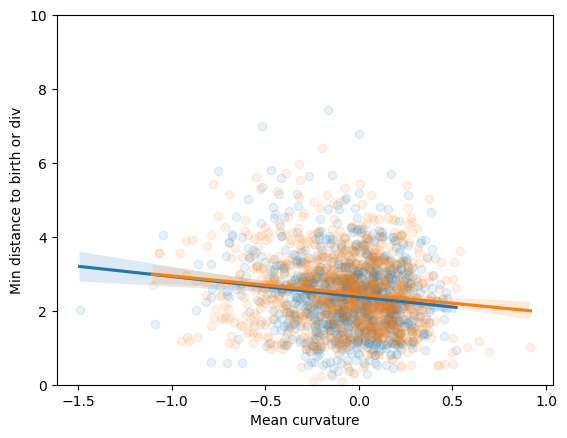

In [161]:
from scipy.spatial import distance

def calculate_distance_matrix_among_events(df, measurement_fields=[['X','Y','Z']]):
    D = distance.squareform(distance.pdist(df[['X','Y','Z']]))
    D[np.eye(len(D)) > 0] = np.nan
    return D

_df1 = pd.concat((births[births['Region','Meta'] == 'R1'],
                 divisions[divisions['Region','Meta'] == 'R1']))
D = calculate_distance_matrix_among_events(_df1)
_df1['Min distance to birth or div','Measurement'] = np.nanmin(D,axis=0)

sb.regplot(_df1.droplevel(axis=1,level=1),x='Mean curvature',y='Min distance to birth or div',scatter_kws={'alpha':0.1})

_df2 = pd.concat((births[births['Region','Meta'] == 'R2'],
                 divisions[divisions['Region','Meta'] == 'R2']))
D = calculate_distance_matrix_among_events(_df2)
_df2['Min distance to birth or div','Measurement'] = np.nanmin(D,axis=0)

sb.regplot(_df2.droplevel(axis=1,level=1),x='Mean curvature',y='Min distance to birth or div',scatter_kws={'alpha':0.1})
plt.ylim([0,10])

_df = pd.concat((_df1,_df2))


In [144]:
import statsmodels.formula.api as smf


model = smf.ols(data = _df.rename(columns={'Min distance to birth or div':'min_dist',
                                  'Mean curvature':'mean_curv'}),
        formula = 'min_dist ~ mean_curv').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               min_dist   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     40.25
Date:                Wed, 29 Oct 2025   Prob (F-statistic):           2.75e-10
Time:                        12:58:13   Log-Likelihood:                -2799.2
No. Observations:                2001   AIC:                             5602.
Df Residuals:                    1999   BIC:                             5614.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4131      0.023    107.019      0.000       2.369       2.457
mean_curv     -0.5211      0.082     -6.345      0.000      -0.682      -0.360
==============================================================================
Omnibus:                      125.360   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.779
Skew:                           0.573   Prob(JB):                     4.50e-36
Kurtosis:                       3.799   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Actual density measurements (# of events in 3D spheres)

Text(0, 0.5, '# of neighboring birth/division witihin 5um')

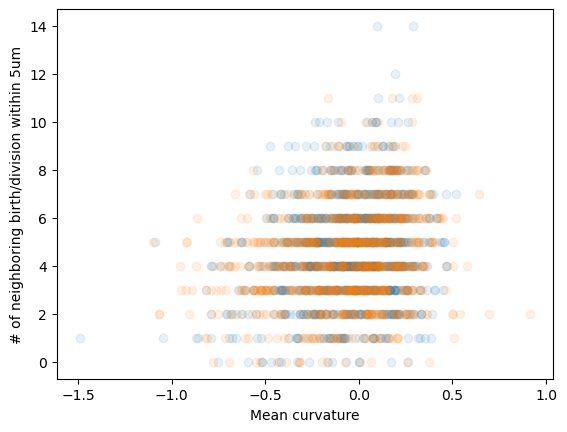

In [171]:
def count_neighboring_events(D,threshold):
    return np.sum(D < threshold,axis=0)

D = calculate_distance_matrix_among_events(_df1)
count_neighboring_events(D,5)
plt.scatter(_df1['Mean curvature','Measurement'],count_neighboring_events(D,5),alpha=0.1)

def count_neighboring_events(D,threshold):
    return np.sum(D < threshold,axis=0)

D = calculate_distance_matrix_among_events(_df2)
count_neighboring_events(D,5)
plt.scatter(_df2['Mean curvature','Measurement'],count_neighboring_events(D,5),alpha=0.1)
plt.xlabel('Mean curvature')
plt.ylabel('# of neighboring birth/division witihin 5um')

In [162]:
def count_neighboring_events(D,threshold):
    return np.sum(D < threshold,axis=0)

D = calculate_distance_matrix_among_events(_df1)
count_neighboring_events(D,5)
plt.scatter(_df1['Mean curvature','Measurement'],count_neighboring_events(D,5),alpha=0.1)

def count_neighboring_events(D,threshold):
    return np.sum(D < threshold,axis=0)

D = calculate_distance_matrix_among_events(_df2)
count_neighboring_events(D,5)
plt.scatter(_df2['Mean curvature','Measurement'],count_neighboring_events(D,5),alpha=0.1)
plt.xlabel('Mean curvature')
plt.ylabel('# of neighboring birth/division witihin 5um')


array([[         nan,   5.8252978 ,  48.29177407, ...,  10.29246891,
        106.64838841,   9.46814137],
       [  5.8252978 ,          nan,  52.50554655, ...,  12.83159408,
        110.41691687,  14.39837563],
       [ 48.29177407,  52.50554655,          nan, ...,  46.26205212,
         59.4521969 ,  44.694338  ],
       ...,
       [ 10.29246891,  12.83159408,  46.26205212, ...,          nan,
        102.6671723 ,  16.99032166],
       [106.64838841, 110.41691687,  59.4521969 , ..., 102.6671723 ,
                 nan, 103.98096427],
       [  9.46814137,  14.39837563,  44.694338  , ...,  16.99032166,
        103.98096427,          nan]])